# Streetcar Delay Prediction - Data Preparation

Use dataset covering Toronto Transit Commission (TTC) streetcar delays 2014 - present to predict future delays and come up with recommendations for avoiding delays.

Source dataset: https://open.toronto.ca/dataset/ttc-streetcar-delay-data/

This notebook contains the common data loading and preparation steps:
- load data from all the tabs of all the XLS files into a single dataframe
- correct type issues
- fix missing values
- clean up anomalies in the route, location, direction and vehicle columns

# Streetcar routes

From https://www.ttc.ca/Routes/Streetcars.jsp

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcar%20routes.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Common imports and variables
Imports and variable definitions that are common to the entire notebook


In [91]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
# common imports
import zipfile
import time
# import datetime, timedelta
import datetime
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import math
from subprocess import check_output
import seaborn as sns
from IPython.display import display

import re
import os


In [92]:
# common variables
# control whether to load data from scratch from original source or from saved dataframe
load_from_scratch = False
# control whether to save dataframe with transformed data
save_transformed_dataframe = True
# control whether rows containing erroneous values are removed from the saved dataset
remove_bad_values = True
# name of file containing pickled dataframe version of input (unprocessed) dataset
pickled_input_dataframe = '2014_2019_upto_june.pkl'
# name of file to which prepared data set is saved as a pickled dataframe
pickled_output_dataframe = '2014_2019_df_cleaned_remove_bad_oct18.pkl'


# Streetcar vehicle IDs CLRV/ALRV

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarCLRV.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

In [93]:
streetcar_vehicles = list(range(4000,4005))+ list(range(4010,4200)) +  list(range(4200,4252)) + [4900]
streetcar_vehicles = streetcar_vehicles + [4400] + list(range(4402,4508))
print("valid streetcars",streetcar_vehicles)

valid streetcars [4000, 4001, 4002, 4003, 4004, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168

# Streetcar vehicle IDs Flexity

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarflexity.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Bus identification
The following links define the valid non-streetcar vehicles that can be delayed by streetcar incidents

- Buses 1xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_1000-1149
- Buses 2xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_2000-2110,_2150-2155,_2240-2485,_2600-2619,_2700-2765,_2767-2858
- Buses 70xx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_7000-7134
- Buses 74xx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_7400-7499,_7500-7619,_7620-7881
- Buses 8xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_8000-8099
- Buses 9xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_9000-9026







In [94]:
bus_vehicles = list(range(1000,1150))+ list(range(2000,2111)) + list(range(2150,2156)) + list(range(2240,2486))
bus_vehicles = bus_vehicles + list(range(2600,2620)) + list(range(2700,2766)) + list(range(2767,2859))
bus_vehicles = bus_vehicles + list(range(7000,7135)) + list(range(7400,7450)) + list(range(7500,7620)) + list(range(7620,7882))
bus_vehicles = bus_vehicles + list(range(8000,8100)) + list(range(9000,9027))
valid_vehicles = streetcar_vehicles + bus_vehicles
print("valid vehicles",valid_vehicles)

valid vehicles [4000, 4001, 4002, 4003, 4004, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 

# Vehicles that are not legitimate subjects of streetcar incidents
The following vehicles are not legitimate subjects of streetcar incidents because they run on completely separate tracks (RT and subway) or they have been retired (6xxx buses).

- RT cars 3xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_3000-3027
- Subway cars 5xxx https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_5000-5371
- Retired Buses 6xxx: https://cptdb.ca/wiki/index.php/Toronto_Transit_Commission_6000-6122


In [95]:
# load the valid list of TTC Streetcar routes
valid_routes = ['501','502','503','504','505','506','509','510','511','512','301','304','306','310']

In [96]:
valid_routes

['501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '509',
 '510',
 '511',
 '512',
 '301',
 '304',
 '306',
 '310']

In [97]:
# original valid directions
# valid_directions = ['E/B','W/B','N/B','S/B','B/W']
# revised valid directions to include lowercasing and removal of '/' and simplify to single letter
valid_directions = ['e','w','n','s','b']

In [98]:
valid_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Load and Save Data
- parse list of XLS files 
- load XLS files, tab by tab, into dataframe
- pickle dataframe for future runs

In [99]:
# get the directory for that this notebook is in and return the directory containing data files

def get_path():
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data')) + "/"
    return(path)


In [100]:
# given a path return the list of xls files in the directory
def get_xls_list(path):
    files = os.listdir(path)
    files_xls = [f for f in files if f[-4:] == 'xlsx']
    print(files)
    print(files_xls)
    return(files_xls)


In [101]:
# load all the tabs of all the XLS files in a list of XLS files, minus tab that has seeded dataframe
def load_xls(path, files_xls, firstfile, firstsheet, df):
    for f in files_xls:
        print("file name",f)
        xlsf = pd.ExcelFile(path+f)
        # iterate through sheets
        for sheet_name in xlsf.sheet_names:
            print("sheet_name",sheet_name)
            if (f != firstfile) or (sheet_name != firstsheet):
                print("sheet_name in loop",sheet_name)
                data = pd.read_excel(path+f,sheet_name=sheet_name)    
                df = df.append(data)
    return (df)

In [102]:
# given a path and a filename, load all the XLS files in the path into a dataframe and save
# to the dataframe to the filename
def reloader(path,picklename):
    # get list of all xls files in the path
    files_xls = get_xls_list(path)
    print("list of xls",files_xls)
    # seed initial tab on initial xls file
    dfnew = pd.read_excel(path+files_xls[0])
    # get the list of sheets in the first file
    xlsf = pd.ExcelFile(path+files_xls[0])
    # load the remaining tabs from all the other xls
    # pass the first file (files_xls[0]) and the first tab in that file (xlsf[0]) explicitly
    dflatest = load_xls(path,files_xls,files_xls[0],xlsf.sheet_names[0], dfnew)
    # save dataframe to pickle
    dflatest.to_pickle(path+ picklename)
    # return dataframe loaded with all tabs of all xls files
    return(dflatest)
    

In [103]:
# define categories for input columns
def define_feature_categories(df):
    allcols = list(df)
    print("all cols",allcols)
    textcols = ['Incident','Location'] # 
    continuouscols = ['Min Delay','Min Gap'] 
                      # columns to deal with as continuous values - no embeddings
    timecols = ['Report Date','Time']
    collist = ['Day','Vehicle','Route','Direction']
    for col in continuouscols:
        df[col] = df[col].astype(float)
    print('texcols: ',textcols)
    print('continuouscols: ',continuouscols)
    print('timecols: ',timecols)
    print('collist: ',collist)
    return(allcols,textcols,continuouscols,timecols,collist)

In [104]:
# fill missing values according to the column category
def fill_missing(dataset,allcols,textcols,continuouscols,timecols,collist):
    print("before mv")
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)

# Load dataframe
- load pickled dataframe
- show info about the dataset


In [105]:
# read in data, either from original XLS files in data directory or from pickled dataframe containing
def ingest_data(path):
    if load_from_scratch:
        unpickled_df = reloader(path,pickled_input_dataframe)
        print("reloader done")
    else:
        unpickled_df = pd.read_pickle(path+pickled_input_dataframe)
    return(unpickled_df)

# General cleanup
- correct types for Route and Vehicle
- fill missing values
- create report-date-time index

In [106]:
# the dataset incorporated some anomalies in the 2019 data, including:
# extraneous Incident ID in April 2019 tab
# Gap and Delay columns in April and June 2019 tabs for what had otherwise been called Min Gap and Min Delay
# this function cleans up these anomalies
def fix_anomalous_columns(df):
    # for rows where there is NaN in the Min Delay or Min Gap columns, copy over value from Delay or Gap
    # df.Temp_Rating.fillna(df.Farheit, inplace=True)
    df['Min Delay'].fillna(df['Delay'], inplace=True)
    df['Min Gap'].fillna(df['Gap'], inplace=True)
    # now that the useful values have been copied from Delay and Gap, remove them
    del df['Delay']
    del df['Gap']
    # remove Incident ID column - it's extraneous
    del df['Incident ID']
    return(df)

In [107]:
def general_cleanup(df):
    # ensure Route and Vehicle are strings, not numeric
    df['Route'] = df['Route'].astype(str)
    df['Vehicle'] = df['Vehicle'].astype(str)
    # remove extraneous characters left from Vehicle values being floats
    df['Vehicle'] = df['Vehicle'].str[:-2]
    # tactical definition of categories
    allcols,textcols,continuouscols,timecols,collist = define_feature_categories(df)
    # fill in missing values
    df.isnull().sum(axis = 0)
    df = fix_anomalous_columns(df)
    df = fill_missing(df,allcols,textcols,continuouscols,timecols,collist)
    # create new column combing date + time (needed for resampling) and make it the index
    df['Report Date Time'] = pd.to_datetime(df['Report Date'].astype(str) + ' ' + df['Time'].astype(str))
    df.index = df['Report Date Time']
    # return the updated dataframe along with the column category lists
    return(df,allcols,textcols,continuouscols,timecols,collist)

# Clean up selected columns
Some values in the input dataset were entered "free form" when they should have been constricted to a pick list. Columns with this problem include:

- Route
- Vehicle
- Direction
- Location


Each of these have a finite set of valid values. We have to fix the data in these columns where multiple tokens have been used to signify the same real-world entity (e.g. "roncesvalles yard." and "roncesvalles carhouse", or where incorrect values have been entered (e.g. Direction that does not correspond with a compass point)

# Clean up Route

In [108]:
def check_route (x):
    if x in valid_routes:
        return(x)
    else:
        return("bad route")

In [109]:
def route_cleanup(df):
    print("Route count pre cleanup",df['Route'].nunique())
    # df['Route'].value_counts()
    # replace bad route with common token
    df['Route'] = df['Route'].apply(lambda x:check_route(x))
    print("route count post cleanup",df['Route'].nunique())
    return(df)    

# Clean up Vehicle

In [110]:
def check_vehicle (x):
    if str.isdigit(x):
        if int(x) in valid_vehicles:
            return x
        else:
            return("bad vehicle")
    else:
        return("bad vehicle")

In [111]:
def vehicle_cleanup(df):
    print("Vehicle count pre cleanup",df['Vehicle'].nunique())
    df['Vehicle'] = df['Vehicle'].apply(lambda x:check_vehicle(x))
    print("Vehicle count post cleanup",df['Vehicle'].nunique())
    return(df)

# Clean up Direction

In [112]:
def check_direction (x):
    if x in valid_directions:
        return(x)
    else:
        return("bad direction")

In [113]:
def direction_cleanup(df):
    print("Direction count pre cleanup",df['Direction'].nunique())
    df['Direction'] = df['Direction'].str.lower()
    df['Direction'] = df['Direction'].str.replace('/','')
    df['Direction'] = df['Direction'].replace({'eastbound':'e','westbound':'w','southbound':'s','northbound':'n'})
    df['Direction'] = df['Direction'].replace('b','',regex=True)
    df['Direction'] = df['Direction'].apply(lambda x:check_direction(x))
    print("Direction count post cleanup",df['Direction'].nunique())
    return(df)

# Clean up Location

In [114]:
def clean_conjunction(intersection):
    intersection = re.sub(" *& *"," and ",intersection)
    intersection = re.sub(" */ *"," and ",intersection)
    return(intersection)

In [115]:
def order_location(intersection):
    # for any string with the format "* and *" if the value before the and is alphabetically
    # higher than the value after the and, swap the values
    conj = " and "
    alpha_ordered_intersection = intersection
    if conj in intersection:
        end_first_street = intersection.find(conj)
        if (end_first_street > 0) and (len(intersection) > (end_first_street + len(conj))):
            start_second_street = intersection.find(conj) + len(conj)
            first_street = intersection[0:end_first_street]
            second_street = intersection[start_second_street:]
            alpha_ordered_intersection = min(first_street,second_street)+conj+max(first_street,second_street)
    return(alpha_ordered_intersection)

In [116]:
def location_cleanup(df):
    print("Location count pre cleanup",df['Location'].nunique())
    # make all location values lower case
    df['Location'] = df['Location'].str.lower()
    # make substitutions to eliminate obvious duplicate tokens
    df['Location'] = df['Location'].replace({'broadviewstation':'broadview station',' at ':' and ',' stn':' station',' ave.':'','/':' and ','roncy':'roncesvalles','carhouse':'yard','yard.':'yard','st. clair':'st clair','ronc. ':'roncesvalles ','long branch':'longbranch','garage':'yard','barns':'yard',' & ':' and '}, regex=True)
    # put intersection values into consistent order
    df['Location'] = df['Location'].apply(lambda x:order_location(x))
    print("Location count post cleanup",df['Location'].nunique())
    return(df)

# Remove bad rows

In [117]:
# remove rows with bad values
def remove_bad(df):
    df = df[df.Vehicle != 'bad vehicle']
    df = df[df.Direction != 'bad direction']
    df = df[df.Route != 'bad route']
    return(df)

# Master cell
This cell contains calls to the other functions in this notebook to complete the data preparation

In [122]:
# master cell to call the other functions
# get the path for data files
path = get_path()
print("path is",path)
# load route direction and delay data datframes
df = ingest_data(path)
print("number of records: ",len(df.index))
print("df.info() output",df.info())
print("df.shape output",df.shape)
print("df.describe() output",df.describe())
print("df.types output",df.dtypes)
df,allcols,textcols,continuouscols,timecols,collist = general_cleanup(df)
df.head()
# get record count by year
from collections import Counter
df_year = pd.DatetimeIndex(df['Report Date Time']).year
print(str(Counter(df_year)))
#Counter(df_year).values()
# check that the values for April 2019 are correct
df[df['Report Date Time'].astype(str).str[:7]=='2019-04']
# cleanup Route
print("df.shape output pre route",df.shape)
df = route_cleanup(df) 
df = vehicle_cleanup(df)
df = direction_cleanup(df)
df = location_cleanup(df)
print("df.shape output post location",df.shape)
if remove_bad_values:
    df = remove_bad(df)
print("Bad route count:",df[df.Route == 'bad route'].shape[0])
print("Bad direction count:",df[df.Direction == 'bad direction'].shape[0])
print("Bad vehicle count:",df[df.Vehicle == 'bad vehicle'].shape[0])
# pickle the cleansed dataframe
print("df.shape output post bad removes",df.shape)
if save_transformed_dataframe:
    file_name = path + pickled_output_dataframe
    df.to_pickle(file_name)
df.head()

path is /storage/manning/data/
number of records:  73473
<class 'pandas.core.frame.DataFrame'>
Int64Index: 73473 entries, 0 to 760
Data columns (total 13 columns):
Day            73473 non-null object
Delay          1813 non-null float64
Direction      73196 non-null object
Gap            1806 non-null float64
Incident       73473 non-null object
Incident ID    889 non-null float64
Location       73232 non-null object
Min Delay      71595 non-null float64
Min Gap        71573 non-null float64
Report Date    73473 non-null datetime64[ns]
Route          73473 non-null int64
Time           73473 non-null object
Vehicle        68941 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 7.8+ MB
df.info() output None
df.shape output (73473, 13)
df.describe() output              Delay          Gap  Incident ID     Min Delay       Min Gap  \
count  1813.000000  1806.000000   889.000000  71595.000000  71573.000000   
mean     15.492002    21.211517     3.9010

,Day,Direction,Incident,Location,Min Delay,Min Gap,Report Date,Route,Time,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2014-01-02 06:31:00,Thursday,e,Late Leaving Garage,dundas and roncesvalles,4.0,8.0,2014-01-02,505,06:31:00,4018,2014-01-02 06:31:00
2014-01-02 12:43:00,Thursday,e,Utilized Off Route,king and shaw,20.0,22.0,2014-01-02,504,12:43:00,4128,2014-01-02 12:43:00
2014-01-02 14:01:00,Thursday,w,Held By,bingham and kingston road,13.0,19.0,2014-01-02,501,14:01:00,4016,2014-01-02 14:01:00
2014-01-02 14:22:00,Thursday,w,Investigation,king st. and roncesvalles,7.0,11.0,2014-01-02,504,14:22:00,4175,2014-01-02 14:22:00
2014-01-02 16:42:00,Thursday,e,Utilized Off Route,bathurst and king,3.0,6.0,2014-01-02,504,16:42:00,4080,2014-01-02 16:42:00


In [120]:
# get record count by year
from collections import Counter
df_year = pd.DatetimeIndex(df['Report Date Time']).year
Counter(df_year)



Counter({2014: 9340,
         2019: 4739,
         2018: 12011,
         2017: 9890,
         2016: 11908,
         2015: 10877})

# Visualize cleaned data

In [129]:
!pip install pixiedust

In [130]:
import pixiedust


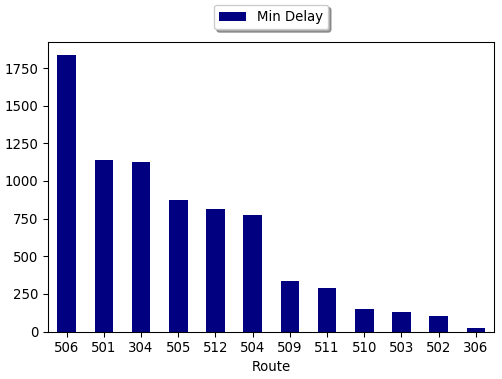

In [131]:
display(df)